In [1]:
import numpy as np
import pandas as pd
import os
import glob
import joblib

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase
import seaborn as sns

from nilearn import plotting 
from nilearn.image import smooth_img, swap_img_hemispheres, resample_img
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.input_data import NiftiMasker
import nibabel as nib

import scipy.stats
from scipy.stats import pearsonr, spearmanr, ttest_ind
import statsmodels.api as sm

import llms_brain_lateralization as lbl
from llms_brain_lateralization import make_dir

In [2]:
rc={'font.size': 12, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('darkgrid')

In [3]:
save_fig = True

In [4]:
if save_fig:
    fig_folder = lbl.figures_folder
    make_dir(fig_folder)

In [5]:
lang = 'cn' # cn or fr 

In [6]:
nifti_masker = NiftiMasker(mask_img='mask_lpp_{}.nii.gz'.format(lang))
nifti_masker.fit()

n_voxels = nifti_masker.n_elements_

print(n_voxels)

26050


In [7]:
glm_folder = lbl.llms_brain_correlations

df_model_info = pd.read_csv('model_info_{}.csv'.format(lang), index_col=0)

model_names = df_model_info['model_name'].to_numpy()
n_parameters = df_model_info['n_parameters'].to_numpy()
n_layers_models = df_model_info['n_layers'].to_numpy() # +1 because of embedding layer

idx_sort_params = np.argsort(n_parameters)
model_names = model_names[idx_sort_params]
n_layers_models = n_layers_models[idx_sort_params]
n_parameters = n_parameters[idx_sort_params]

In [8]:
df_model_info

,model_name,n_parameters,n_layers,n_hid
0,gpt2-tiny-chinese,11600784,4,312
1,gpt2-base-chinese,102068736,12,768
2,Qwen1.5-0.5B,463987712,24,1024
3,Qwen1.5-1.8B,1836828672,24,2048
4,Qwen1.5-4B,3950369280,40,2560
5,Qwen1.5-7B,7721324544,32,4096
6,Qwen1.5-14B,14167290880,40,5120
7,Qwen2-0.5B,494032768,24,896
8,Qwen2-1.5B,1543714304,28,1536
9,Qwen2-7B,7615616512,28,3584


In [9]:
n_models = len(model_names)

In [10]:
corr_layers_voxels_models = []
for model_name, n_layers in zip(model_names, n_layers_models):
    corr_layers_voxels = []
    for idx_layer in range(n_layers): 
        filename = os.path.join(glm_folder, '{}_layer-{}_corr_{}.gz'.format(model_name, idx_layer, lang))
        with open(filename, 'rb') as f:
            corr_voxels = joblib.load(f)
        corr_layers_voxels.append(corr_voxels)
    corr_layers_voxels_models.append(np.array(corr_layers_voxels))

In [11]:
color_models = list(sns.color_palette('plasma', n_colors=len(corr_layers_voxels_models)))

In [12]:
# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models = np.array([np.max(corr_layers_voxels, axis=0) for corr_layers_voxels in corr_layers_voxels_models])

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models = np.array([np.mean(corr_voxels) for corr_voxels in corr_voxels_models])

# mean correlation for each layer of each model, averaged over all voxels
# n_models x n_layers 
corr_layers_models = [np.mean(corr_layers, axis=1) for corr_layers in corr_layers_voxels_models]

# restrict to left and right hemisphere
corr_l_models = corr_voxels_models[:,:n_voxels//2]
corr_r_models = corr_voxels_models[:,n_voxels//2:]

In [13]:
def plot_xy(xvalue, yvalue, xlabel=None, ylabel=None, logx=False, invert_xaxis=False, figsize=(6.4, 4.8)):        
    fh = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    sns.regplot(x=xvalue,
                y=yvalue,
                logx=logx, ax=ax, ci=None);
    if logx:
        ax.set_xscale('log')
    if invert_xaxis:
        ax.invert_xaxis()
    ax.set_xlabel(xlabel)      
    ax.set_ylabel(ylabel)
    return fh

def pvalue2str(pvalue):
    if pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return 'ns'

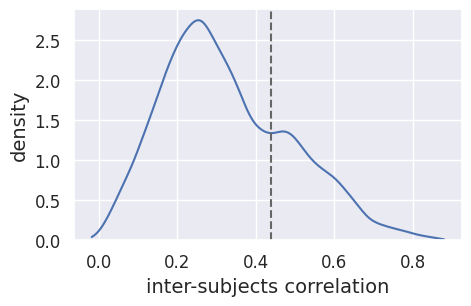

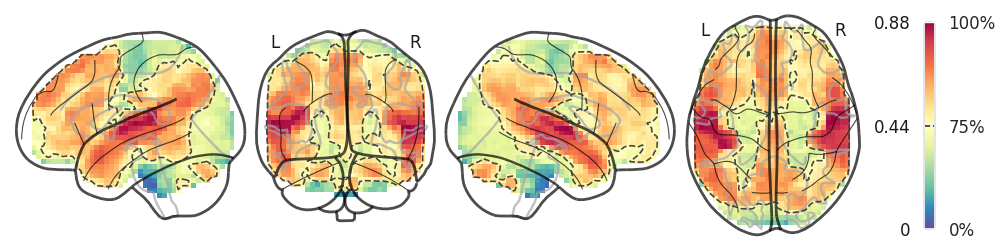

In [14]:
########################################## Using reliable voxels: best 25% voxels ##########################################

# inter-subject correlation (isc)
filename = 'isc_10trials_{}.gz'.format(lang)
isc_10trials = joblib.load(filename)
isc = np.mean(isc_10trials, axis=0)

is_voxel_reliable = isc > np.percentile(isc, 75)

#### rv for reliable voxels

# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models_rv = np.array([np.max(corr_layers_voxels[:,is_voxel_reliable], axis=0)
                                  for corr_layers_voxels in corr_layers_voxels_models])

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models_rv = np.array([np.mean(corr_voxels[is_voxel_reliable]) for corr_voxels in corr_voxels_models])

# mean correlation for each layer of each model, averaged over all voxels
# n_models x n_layers 
corr_layers_models_rv = [np.mean(corr_layers[:, is_voxel_reliable], axis=1) for corr_layers in corr_layers_voxels_models]

# restrict to left and right hemisphere
# n_models x n_voxels//2
corr_l_models_rv = corr_l_models[:,is_voxel_reliable[:n_voxels//2]]
corr_r_models_rv = corr_r_models[:,is_voxel_reliable[n_voxels//2:]]

fh = plt.figure(figsize=(5,3))
ax = plt.subplot(111)
sns.kdeplot(isc, cut=0., ax=ax)
plt.axvline(np.percentile(isc, 75), ls='--', c='0.4');
plt.xlabel('inter-subjects correlation')
plt.ylabel('density')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'reliable_voxels_distribution_{}.pdf'.format(lang)), bbox_inches='tight', facecolor=(1,1,1,0))

imgtmp = nifti_masker.inverse_transform(isc)
fh = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
display = plotting.plot_glass_brain(imgtmp, threshold=0., display_mode='lyrz', 
                          vmin=0., cmap='Spectral_r', 
                          plot_abs=True, colorbar=True, axes=ax)
display.add_contours(imgtmp, levels=[np.percentile(isc, 75)], colors='0.2', linewidths=1.2, alpha=0.9, linestyles='dashed')

display._colorbar_ax.set_yticks([0., np.percentile(isc, 75), np.max(isc)])
ylim = display._colorbar_ax.get_ylim()  
ax2 = display._colorbar_ax.twinx()
ax2.set_ylim(ylim)
ax2.set_yticks([0., np.percentile(isc, 75), np.max(isc)], ['0%', '75%', '100%'])
ax2.yaxis.set_tick_params(width=0)
#display._cbar._
ax2.axhline(np.percentile(isc, 75), ls='--', lw=1.2, color='0.2')

plotting.show() 

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'reliable_voxels_75_{}.pdf'.format(lang)), bbox_inches='tight', facecolor=(1,1,1,0))

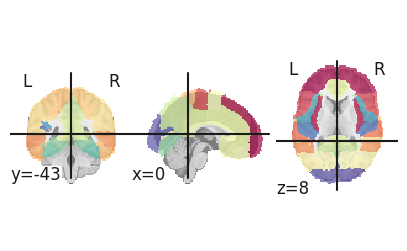

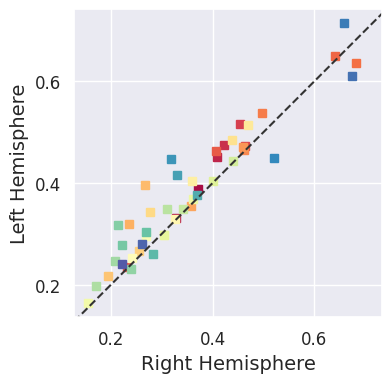

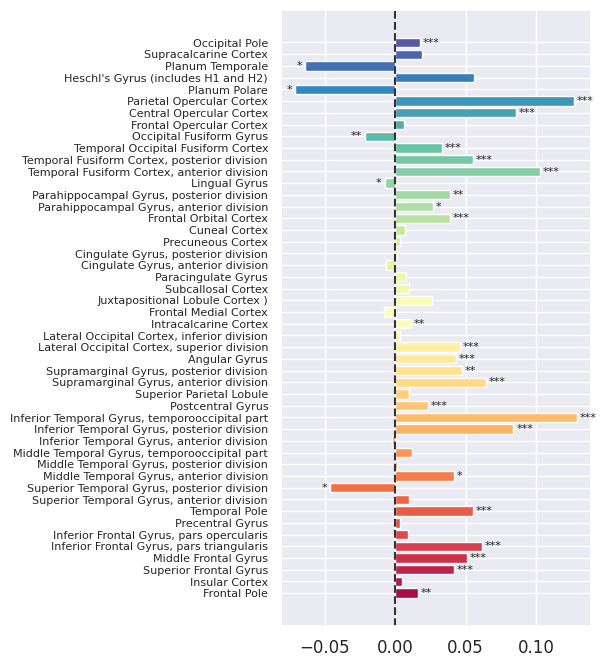

In [15]:
atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr0-2mm', symmetric_split=True)

fh = plt.figure(figsize=(5,3))
ax = plt.subplot(111)
plotting.plot_roi(atlas['maps'], cmap='Spectral', axes=ax);
plt.show()

parcels = atlas['maps']
parcels = resample_img(parcels, interpolation='nearest',
                    target_affine=nifti_masker.mask_img_.affine, 
                    target_shape=nifti_masker.mask_img_.shape)

parcels_t = nifti_masker.transform(parcels)[0]
n_parcels = np.unique(parcels_t).shape[0]-1

parcels_colors = sns.color_palette('Spectral', n_colors=n_parcels//2)

idx_parcels = [np.flatnonzero(parcels_t == i) for i in range(1, n_parcels+1)]

parcel_names = []
for label in atlas['labels'][1:][::2]:
    parcel_names.append(label.replace('Left ', '').replace('(formerly Supplementary Motor Cortex', ''))

sns.set_style('darkgrid')

fh = plt.figure(figsize=(6,4))
for idx_parcel_l, idx_parcel_r, parcel_name, parcels_color in zip(idx_parcels[::2], idx_parcels[1::2], parcel_names, parcels_colors):
    plt.plot(np.mean(isc[idx_parcel_r]), np.mean(isc[idx_parcel_l]), 's', 
             color=parcels_color, label=parcel_name)
plt.axis('equal')
plt.xticks([0.2, 0.4, 0.6])
plt.yticks([0.2, 0.4, 0.6])
plt.xlabel('Right Hemisphere')
plt.ylabel('Left Hemisphere')
plt.axis('square')
xlim = plt.xlim()
plt.plot(xlim, xlim, '--', c='.2')
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'atlas_isc_l_vs_r_{}.pdf'.format(lang)), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(4,8))
for i, (idx_parcel_l, idx_parcel_r, parcel_name) in enumerate(zip(idx_parcels[::2], idx_parcels[1::2], parcel_names)):
    lr_diff = np.mean(isc[idx_parcel_l]) - np.mean(isc[idx_parcel_r])
    plt.barh(i, lr_diff, label=parcel_name, color=parcels_colors[i])
    p = ttest_ind(isc[idx_parcel_l], isc[idx_parcel_r]).pvalue
    if pvalue2str(p) != 'ns':
        if lr_diff > 0.:
            plt.text(lr_diff + 0.002, i, pvalue2str(p), fontsize=8, ha='left', va='center')
        else: 
            plt.text(lr_diff - 0.002, i, pvalue2str(p), fontsize=8, ha='right', va='center')   
plt.axvline(0., ls='--', c='0.2')
plt.yticks(range(n_parcels//2), parcel_names, fontsize=8)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'atlas_isc_l_minus_r_{}.pdf'.format(lang)), bbox_inches='tight', facecolor=(1,1,1,0))

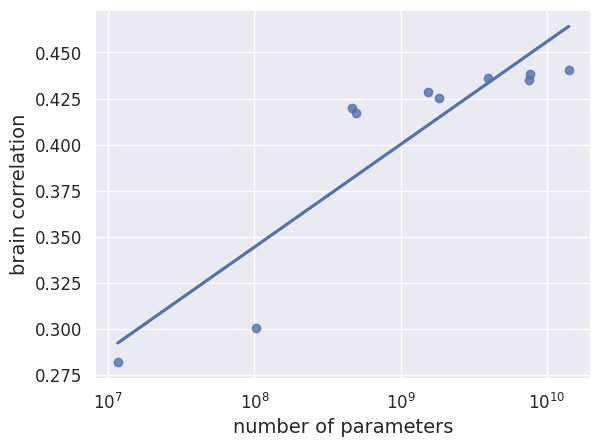

In [16]:
fh = plot_xy(n_parameters, corr_models_rv, 
             xlabel='number of parameters', ylabel='brain correlation', 
             logx=True)
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_params_rv_{}.pdf'.format(lang)), bbox_inches='tight', facecolor=(1,1,1,0))

In [17]:
################################ baselines ################################

# look at random vectors
corr_random_300 = []
for seed in range(1,11):
    model_name ='random_vector_300d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-0_corr_{}.gz'.format(model_name, lang))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_300.append(corr)
corr_random_300 = np.mean(corr_random_300, axis=0)

corr_random_1024 = []
for seed in range(1,11):
    model_name ='random_vector_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-0_corr_{}.gz'.format(model_name, lang))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_1024.append(corr)
corr_random_1024 = np.mean(corr_random_1024, axis=0)

# look at random embeddings
corr_random_emb_300 = []
for seed in range(1,11):
    model_name ='random_embedding_300d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-0_corr_{}.gz'.format(model_name, lang))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_emb_300.append(corr)
corr_random_emb_300 = np.mean(corr_random_emb_300, axis=0)

corr_random_emb_1024 = []
for seed in range(1,11):
    model_name ='random_embedding_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-0_corr_{}.gz'.format(model_name, lang))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_emb_1024.append(corr)
corr_random_emb_1024 = np.mean(corr_random_emb_1024, axis=0)

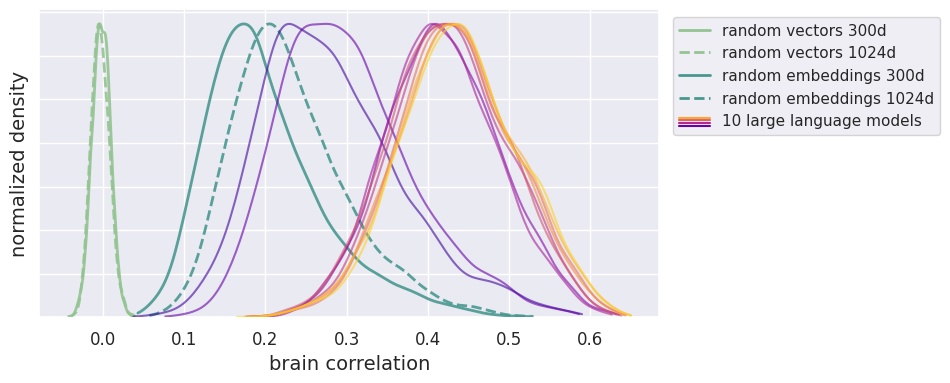

In [18]:
color_baseline = sns.color_palette('crest', n_colors=15)[::5]

class MyLegendHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        lines = []
        n_lines = 4
        color_models_legend = list(sns.color_palette('plasma', n_colors=n_lines))
        for i, color in enumerate(color_models_legend):
             lines.append(plt.Line2D([x0,y0+width], 
                               [i/n_lines*height,i/n_lines*height], 
                               color=color))
        return lines

fh = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
sns.kdeplot(corr_random_300[is_voxel_reliable], c=color_baseline[0], lw=2, alpha=0.9, cut=0., ax=ax);
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
plt.xlabel('brain correlation')
plt.ylabel('normalized density')
ax = plt.twinx()
sns.kdeplot(corr_random_1024[is_voxel_reliable], c=color_baseline[0], ls='--', lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_300[is_voxel_reliable], c=color_baseline[1], lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_1024[is_voxel_reliable], c=color_baseline[1], ls='--', lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
for corr_voxels, color in zip(corr_voxels_models, color_models):
    ax = plt.twinx()
    sns.kdeplot(corr_voxels[is_voxel_reliable], color=color, lw=1.5, alpha=0.6, cut=0., ax=ax);
    ax.grid(None)
    ax.axis('off')

plt.plot([], c=color_baseline[0], lw=2, label='random vectors 300d')
plt.plot([], c=color_baseline[0], lw=2, ls='--', label='random vectors 1024d')
plt.plot([], c=color_baseline[1], lw=2, label='random embeddings 300d')
plt.plot([], c=color_baseline[1], lw=2, ls='--', label='random embeddings 1024d')

hllm, = plt.plot([], label='{} large language models'.format(len(model_names)))

ax.tick_params(axis='y', labelleft='off')

plt.legend(handler_map={hllm: MyLegendHandler()}, bbox_to_anchor=(1.01,1), loc='upper left')

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'distribution_correlation_models_baselines_rv_{}.pdf'.format(lang)), bbox_inches='tight', facecolor=(1,1,1,0))

In [19]:
################################ L/R Asymmetries ################################
# on the most 25% reliable voxels

#l r asym in baselines
for corr_voxels in [corr_random_300, corr_random_1024,
                    corr_random_emb_300, corr_random_emb_1024]:
    print(corr_voxels[:n_voxels//2][is_voxel_reliable[:n_voxels//2]].mean()
          - corr_voxels[n_voxels//2:][is_voxel_reliable[n_voxels//2:]].mean())

-0.0027456336611714994
0.00010172517006725975
-0.017746593466091726
-0.006898503059761446


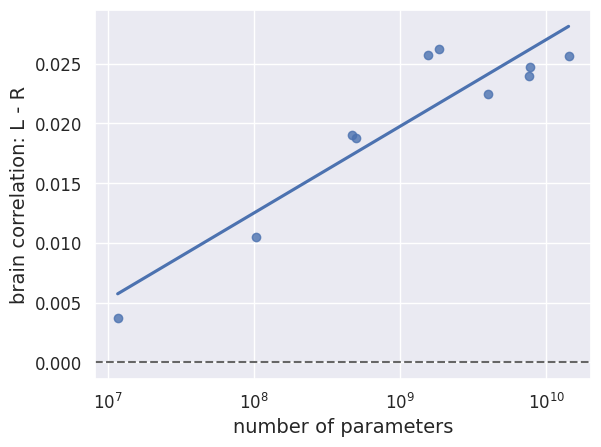

In [20]:
fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=n_parameters, 
            y=(np.mean(corr_l_models_rv, axis=1)
               -np.mean(corr_r_models_rv, axis=1)), 
            logx=True, ax=ax, ci=None);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation: L - R')
ax.axhline(0., ls='--', c='0.4', zorder=1);

plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_l_minus_r_params_rv_{}.pdf'.format(lang)), bbox_inches='tight', facecolor=(1,1,1,0))